# Aligning adult mouse coronal brain sections with the Allen Brain Altas

In this notebook, we take two single cell resolution spatial transcriptomics datasets of serial breast cancer sections profiled by the Xenium technology and align them to each other. You can download additional MERFISH datasets and find more details about this data here: https://info.vizgen.com/mouse-brain-data



We will use STalign to achieve this alignment. We will first load the relevant code libraries.

In [1]:
#Import dependencies

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import sys
sys.path.insert(1,'/home/manju/Documents/STalign/') #path to tools.py
import tools

We have already downloaded MERFISH datasets (link found above) and stored them in a folder called ______

Now, we can read in the cell infomation using pandas as pd.

We must load all cell x and y positions into the variable x and y respectively. Importantly, the *scale* of the loaded data must approximately match the Allen Brain Atlas, where ~1 pixel unit is ~1 um

In [2]:
#Load file

filename = '__'
df = pd.read_csv(r'/home/manju/Documents/test/s1r1_metadata.csv.gz')

#Load x position
x = np.array(df['center_x']) #change to x positions of cells

#Load y position
y = np.array(df['center_y']) #change to column y positions of cells


In [3]:
dx=10
blur = 1

Now we can load in data from the Allen Brain Altas.

We need to load in and save files containing the ontology of regions, a 3D cell density atlas, and annotations of brain regions in the aforementioned 3D atlas.

Depending on which Allen Atlas you would like to use, you can change the url that you download these files from. In this example, we are aligning the adult mouse (P56) Allen Atlas.

In [4]:
def download_aba_ontology(url,file_name): #where to store ontology info
        #Download and store ontology
    url = url#'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]'
    r = requests.get(url)
    print(r)
    with open(file_name,'w') as f:
        f.write(r.text)
    ontology_name = file_name

    O = pd.read_csv(ontology_name)

    # store the ontology in a dictionary
    namesdict = defaultdict(lambda: 'unk')
    namesdict[0] = 'bg'

    # we need to add the structure names from the structure_id
    for i,n in zip(O['id'],O['acronym']):
        namesdict[i] = n
    return ontology_name,namesdict

In [5]:
url = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]'

ontology_name,namesdict = download_aba_ontology(url, 'allen_ontology.csv') #url for adult mouse

<Response [200]>


In [6]:
def download_aba_image_labels(imageurl, labelurl, imagefile, labelfile):
        url = imageurl#'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/ara_nissl_50.nrrd'
        r = requests.get(url, stream=True)
        with open(imagefile, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
        imagefile = imagefile

        url = labelurl#'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
        r = requests.get(url, stream=True)
        with open(labelfile, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
        labelfile = labelfile
        return imagefile, labelfile

In [7]:
imageurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/ara_nissl_50.nrrd'
labelurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
imagefile, labelfile = download_aba_image_labels(imageurl, labelurl, 'aba_nissl.nrrd', 'aba_annotation.nrrd')

Our first step in this alignment will be to rasterize the single cell centroid positions into an image. This converts our x and y arrays of cells into a pixelated image. For this example, we choose to rasterize at a resolution of 15 (um). 



In [8]:
#Rasterize Image
X_,Y_,W = tools.rasterize(x,y,dx=dx, blur = blur,draw=False)     

We can visualize the resulting rasterized image.

<IPython.core.display.Javascript object>


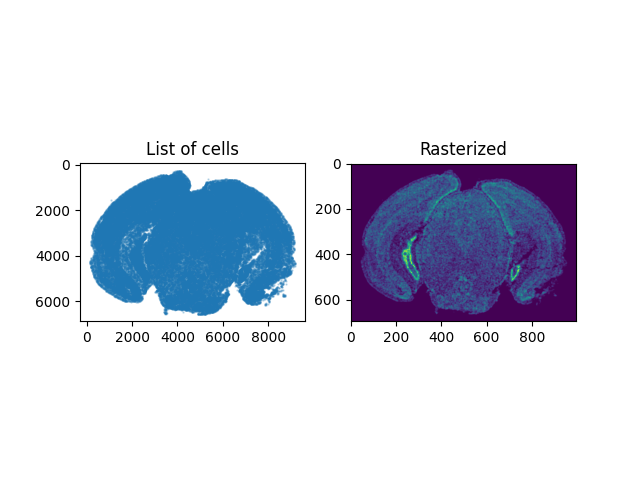

Text(0.5, 1.0, 'Rasterized')

In [9]:
#Plot unrasterized/rasterized images
fig,ax = plt.subplots(1,2)
ax[0].scatter(x,y,s=0.5,alpha=0.25)
ax[0].invert_yaxis()
ax[0].set_title('List of cells')
ax[0].set_aspect('equal')

W = W[0]
extent = (X_[0],X_[-1],Y_[0],Y_[-1])    
ax[1].imshow(W,  origin='lower')    
ax[1].invert_yaxis()    
ax[1].set_title('Rasterized')

# save figure
#fig.canvas.draw()    
#fig.savefig(outname[:-4]+'_image.png')

Now we need to find an approximate slice number in the Allen Atlas to initialize the alignment. Evaluate whether the value of slice is similar to the target image by viewing a side by side comparison of the ABA slice and the target image. If not, change the value of slice. In this example, slice = 0 is anterior and slice = ___ is posterior.

<IPython.core.display.Javascript object>


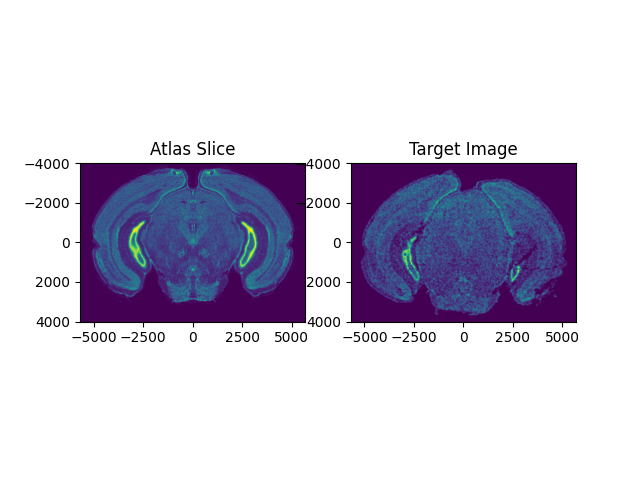

In [10]:
#find slice
#peruse through images in atlas
# Loading the atlas
slice = 177

vol,hdr = nrrd.read(imagefile)
A = vol    
vol,hdr = nrrd.read(labelfile)
L = vol

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = tools.extent_from_x(xA[1:])
ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()    


Next, we need to find an approximate rotation angle of the Allen Atlas to initialize the alignment. Evaluate whether the rotation of the atlas is similar to the target image by viewing a side by side comparison of the ABA slice and the target image. If not, change the value of theta_deg. Note: the rotation here is defined in degrees.

<IPython.core.display.Javascript object>


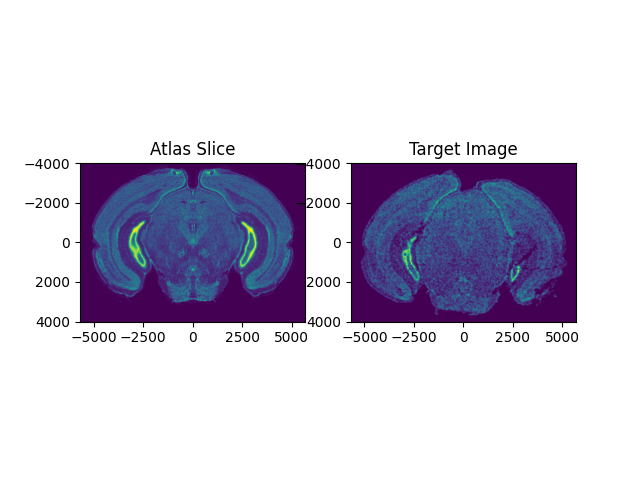

In [11]:
from scipy.ndimage import rotate

theta_deg = 0

fig,ax = plt.subplots(1,2)
extentA = tools.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()    


Next, specify if there are any points on the image above that can be approximately matched with eachother and add them in the following format. This helps speed up alignment. (OPTIONAL)


In [12]:
points_atlas = np.array([[0,2580]])
points_target = np.array([[8,2533]])
Li,Ti = tools.L_T_from_points(points_atlas,points_target)

We can define atlas and target points, xI and xJ, as well as atlas and target images, I and J. 

In [13]:
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

Now that we can chosen the slice number and rotation angle, we are ready to initialize parameters related to our alignment. 

In [14]:
sigmaA = 2 #standard deviation of artifact intensities
sigmaB = 2 #standard deviation of background intensities
sigmaM = 2 #standard deviation of matching tissue intenities
muA = torch.tensor([3,3,3],device='cpu') #average of artifact intensities
muB = torch.tensor([0,0,0],device='cpu') #average of background intensities


We can change the parameters above by looking at the intensity histogram of our target image (below). We need to consider intensities of artifacts (tissue that is present in the target image and absent in the atlas), which is usually in the upper range of intensity values. We also need to find the intensity of the background values that does not correspond to any tissue, usually around 0, and standard deviations for these values. The matching tissue intensities are regions that should have tissue that can be aligned in both the atlas and the target image.

<IPython.core.display.Javascript object>


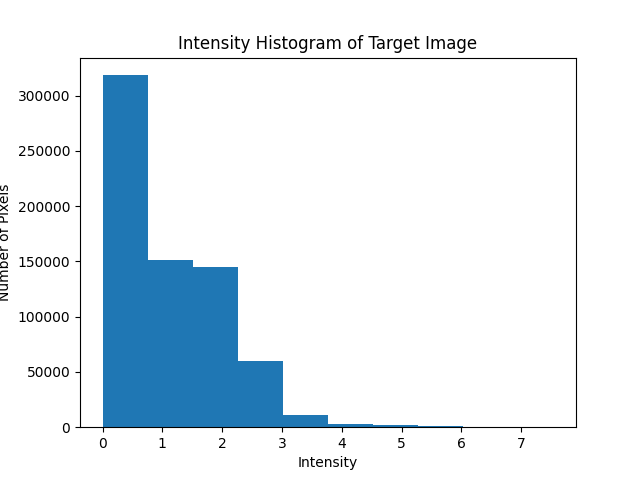

Text(0.5, 1.0, 'Intensity Histogram of Target Image')

In [15]:
fig,ax = plt.subplots()
ax.hist(J.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

The following parameters vary depending on your target image and the duration & accuracy of the alignment. The scale parameters refer to a scaling of the atlas in (x, y, z) to match the size of the target image. The nt parameter ensures smoothness and invertibility of the image transformation. The niter refers to the number of iteration steps in gradient descent to achieve minimum error between the altas and the target image.

In [16]:
# initialize variables
scale_x = 0.9 #default = 0.9
scale_y = 0.9 #default = 0.9
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)

Now, we can perform alignment of the atlas to our target slice.

/home/manju/anaconda3/envs/stalign_ma/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


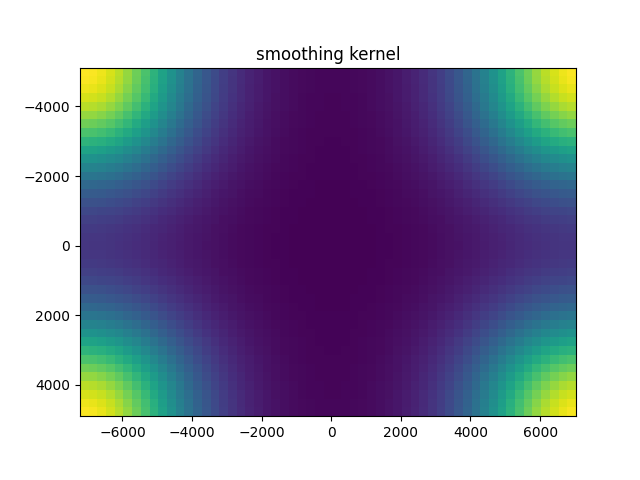

<IPython.core.display.Javascript object>


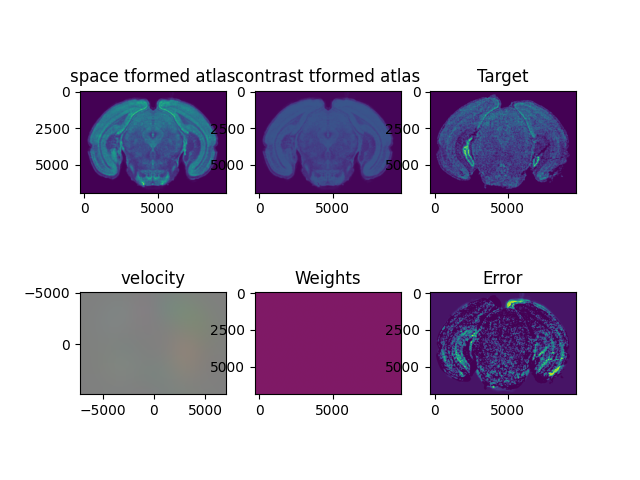

<IPython.core.display.Javascript object>


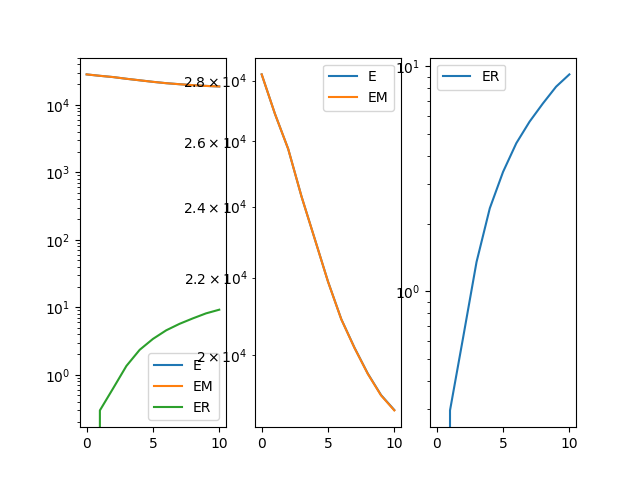

/home/manju/Documents/STalign/tools.py:1676: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


In [17]:
#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
mat,v,xv,Xs = tools.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=20,
    device='cpu',
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB #average of background intensities
)


Once we have aligned the atlas to our target image, we can project the brain regions defined in the atlas to our target image and export these annotations, along with information about the positions of the atlas that align with the slice.

In [18]:
import copy
def analyze3Dalign(labelfile, xI, Xs, dx, scale_x=scale_x, scale_y=scale_y,x=x,y=y, X_=X_, Y_=Y_, device='cpu'):
    # map the annotations
    #xS = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxS,dxS)]
    vol,hdr = nrrd.read(labelfile)
    xI_ = copy.deepcopy(xI)
    #Xs_ = copy(Xs)

    # we require 64 bit here or there will be trouble
    S_ = torch.as_tensor(vol.astype(np.float64)[None],dtype=torch.float64,device=device) # note we need float for interp
    AS_ = torch.round(tools.interp3D(xI_,S_,Xs.permute(3,0,1,2).double(),mode='nearest')).int()

    df_ = pd.DataFrame()
    x_ = copy.deepcopy(x)
    y_ = copy.deepcopy(y)
    X__ = copy.deepcopy(X_)
    Y__ = copy.deepcopy(Y_)
    #df1 = df[1:0]
    # here is an update
    col = ((x_ - X__[0])/dx).astype(int)
    row = ((y_ - Y__[0])/dx).astype(int)
    df_['struct_id'] = AS_[0,0,row,col].detach().cpu()
    df_['coord0'] = Xs[0,row,col,0].detach().cpu()
    df_['coord1'] = Xs[0,row,col,1].detach().cpu()
    df_['coord2'] = Xs[0,row,col,2].detach().cpu()
    df_['x'] = x_
    df_['y'] = y_
    
    all_names = [namesdict[i] for i in df_['struct_id']]
    df_['acronym'] = all_names    
    
    return df_ 

In [19]:
df_ = analyze3Dalign(labelfile, xI, Xs, dx, device = 'cpu')

Now, we can explore our alignment and brain region annotations! First we will load in the csv file from the previous section.

In [20]:
#file = pd.read_csv('annotations.csv')

Visualize slices on top of eachother

In [21]:
It = torch.tensor(I,device='cpu',dtype=torch.float64)
AI = tools.interp3D(xI,It,Xs.permute(3,0,1,2),padding_mode="border")
Ishow_source = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
Jt = torch.tensor(J,device='cpu',dtype=torch.float64)
Ishow_target = Jt.permute(1,2,0).cpu()/torch.max(Jt).item()


In [22]:
AI.shape

torch.Size([2, 1, 696, 995])

<IPython.core.display.Javascript object>


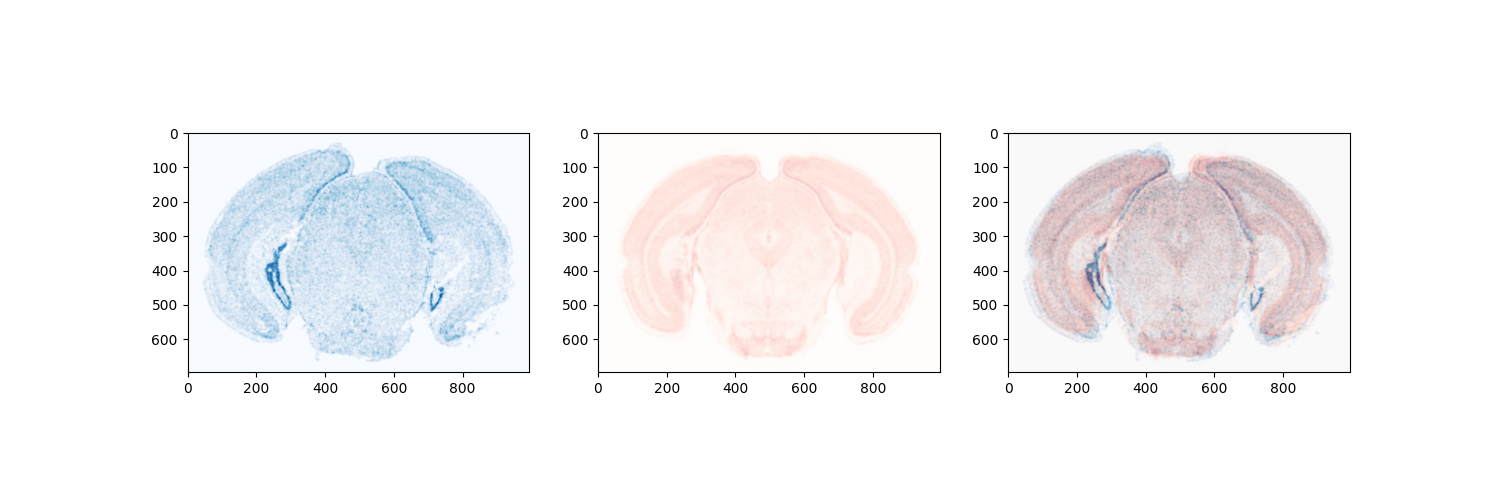

In [23]:
import matplotlib as mpl
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax2 = ax[0].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax1 = ax[1].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.2)
ax2 = ax[2].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax1 = ax[2].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.3)


plt.show()

We can view the slice of the atlas that aligned to the target image. Note that the slice is curved with respect to the Allen Atlas, capturing the *not truely coronal* nature of the target slice. 

In [24]:
df_

,struct_id,coord0,coord1,coord2,x,y,acronym
0,0,2539.523954,603.216966,-5240.653684,156.563284,4271.326432,bg
1,0,2539.656145,592.036798,-5240.774523,156.509284,4256.962431,bg
2,0,2540.052721,558.496289,-5241.137038,159.965284,4228.180431,bg
3,0,2538.609277,670.133127,-5228.288015,167.579284,4323.868433,bg
4,0,2538.995194,647.937621,-5240.170333,160.559284,4308.802433,bg
...,...,...,...,...,...,...,...
78324,0,2422.980307,666.420413,5225.128730,9154.007886,4445.528506,bg
78325,0,2423.894853,644.955301,5155.135150,9088.829884,4423.712505,bg
78326,0,2423.044275,643.730276,5248.135757,9170.261887,4431.758506,bg
78327,0,2424.033287,633.763004,5155.013315,9086.183884,4417.016505,bg


<IPython.core.display.Javascript object>


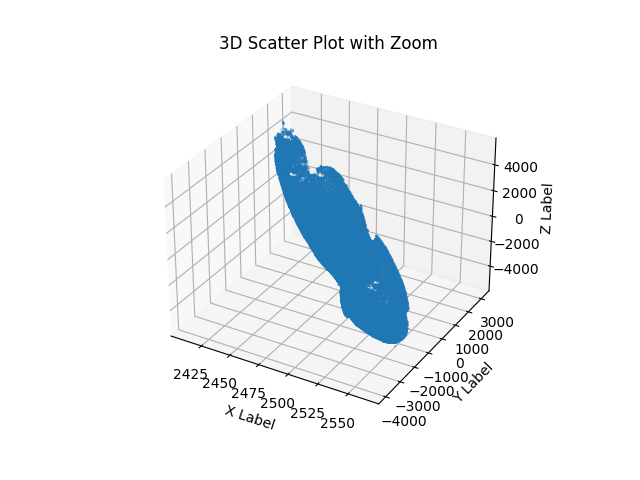

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mplcursors

# Sample data (replace these with your own x, y, and z input arrays)
x = df_['coord0']
y = df_['coord1']
z = df_['coord2']

# Create a 3D scatter plot with zoom functionality
def create_scatter_plot(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z,s=0.1)

    # Set labels and title
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Scatter Plot with Zoom')

    # Enable interactive zooming with the scroll wheel
    #ax.mouse_init()

    # Enable interactive data cursor
    #mplcursors.cursor(ax, hover=True)

    plt.show()

create_scatter_plot(x, y, z)


In [27]:
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

# Sample data (replace these with your own x, y, and z input arrays)
x = np.random.rand(100)
y = np.random.rand(100)
z = np.random.rand(100)

def create_scatter_plot(x, y, z):
    # Create a 3D scatter plot
    fig = px.scatter_3d(x=x, y=y, z=z)

    # Set labels and title
    fig.update_layout(scene=dict(
        xaxis_title="X Label",
        yaxis_title="Y Label",
        zaxis_title="Z Label"
    ), title="3D Scatter Plot with Zoom and Fast Rotation")

    fig.show()

create_scatter_plot(x, y, z)

We can compare the slice in the previous image to the target slice, plotted below.

<IPython.core.display.Javascript object>


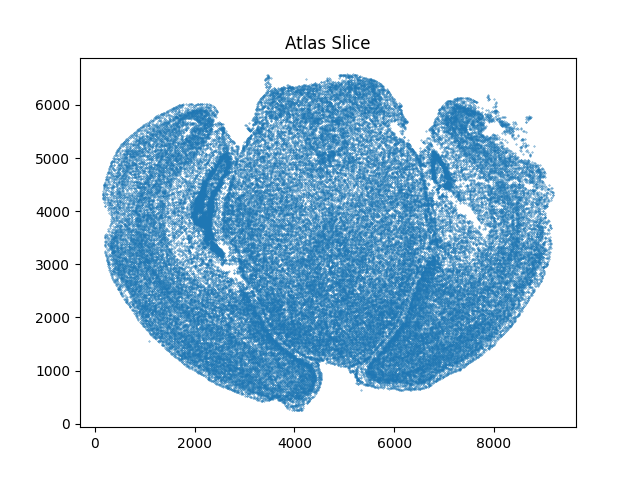

Text(0.5, 1.0, 'Atlas Slice')

In [28]:
#Compare to target slice
fig,ax = plt.subplots()
extentA = tools.extent_from_x(xA[1:])
ax.scatter(df_['x'], df_['y'], s= 0.1)
ax.set_title('Atlas Slice')

We can also plot all of the brain regions that are captured in the slice, as defined by our alignment.

In [76]:
def plot_brain_regions(file):
    #plot brain regions
    brain_regions = np.unique(file['acronym'])
    fig,ax = plt.subplots()
    extentA = tools.extent_from_x(xA[1:])
    for i in range(len(brain_regions)):
        region_df = file[file['acronym']==brain_regions[i]]

        ax.scatter(region_df['x'], region_df['y'], label = brain_regions[i],s= 0.1)   
        ax.legend()

<IPython.core.display.Javascript object>


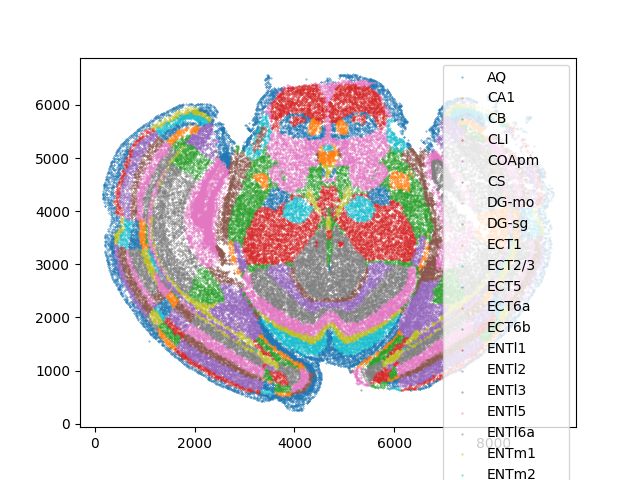

In [77]:
plot_brain_regions(df_)

If we also interested in only a few regions, in this example let's take HPF and CA1, we can plot those regions using the following function.

In [46]:
def plot_subset_brain_regions(file, brain_regions):
    #plot brain regions
    brain_regions = brain_regions
    fig,ax = plt.subplots()
    extentA = tools.extent_from_x(xA[1:])
    ax.scatter(file['x'], file['y'],color = 'grey',s= 0.1)   
    for i in range(len(brain_regions)):
        region_df = file[file['acronym']==brain_regions[i]]

        ax.scatter(region_df['x'], region_df['y'], label = brain_regions[i],s= 0.1)   
        ax.legend()

<IPython.core.display.Javascript object>


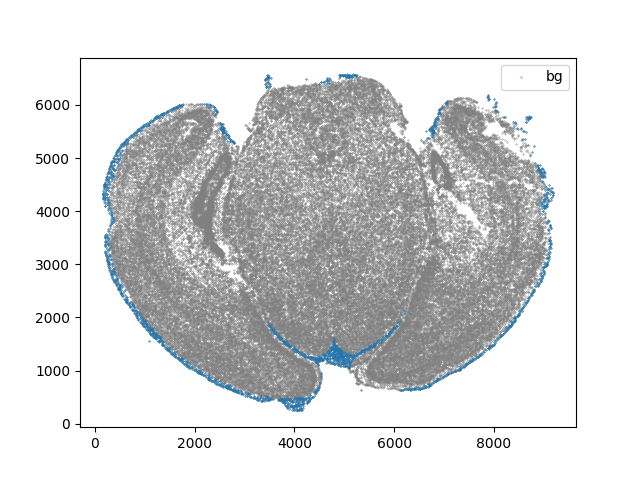

In [49]:
brain_regions = ['bg']
plot_subset_brain_regions(df_, brain_regions)